## Estudo Aço Brasil

#### 1 - Instituto Aço Brasil é a entidade representativa das empresas brasileiras produtoras de aço. Antigo Instituto Brasileiro de Siderurgia, ele foi fundado em 31 de maio de 1963.

#### 2 - O instituto realiza estudos/pesquisas relacionados à produção, equipamentos e tecnologia, matérias-primas e energia, tendências de mercado, novas aplicações do aço e relações industriais.

- Estarei fazendo uma análise estatística simples dos dados fornecidos mensalmente pelo Instituto.
<br>

- https://acobrasil.org.br/site/estatistica-mensal/
- https://acobrasil.org.br/site/indice-de-confianca-da-industria-do-aco/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import warnings
from statsmodels.tsa.arima.model import ARIMA
from uniqed.runners.tof_run import detect_outlier
warnings.filterwarnings('ignore') # Ignorar qualquer aviso...
sns.set_style("darkgrid")
# (*) Exclui as vendas para dentro do parque.
# (**) Vendas faturadas pelas usinas.
# (***) Vendas Internas
# Nota: Compreende os dados da laminadora SILAT
# Adquirida pela Gerdau a partir de dezembro de 2020

filepath = ["C:/Users/Bem-vindo(a)/Desktop/Faculdade/ICIA_seriehistorica.xlsx",
"C:/Users/Bem-vindo(a)/Desktop/Faculdade/MensalAco.xlsx"]

def dados_mensais(filepath): 
    dados_meses = pd.read_excel(filepath[1])
    indice_lista = ["Exportações" if row["Especificação"] == "Comércio Exterior" else 
                "Importações" if row["Especificação"] == "Importações" else "Produção" 
                if row["Especificação"] == "Produção" else "Vendas Externas" 
                if row["Especificação"] == "Vendas Externas" else "Consumo Aparente" 
                if row["Especificação"] == "Consumo Aparente"
                else "Vendas Internas" for index, row in dados_meses.iterrows()]

    multi_indice = pd.MultiIndex.from_arrays([indice_lista],names=["Especificação"])
    dados_meses.set_index(multi_indice,inplace=True)
    dados_meses.set_index(["Especificação","Tipo"],inplace=True)
    
    return dados_meses

dados_meses = dados_mensais(filepath)
dados_meses

2013-01-01  \
Especificação     Tipo                                                     
Produção          Aço Bruto                                     2769.437   
                  Laminados                                     2051.441   
                  Semiacabados P/ Vendas                         470.371   
                  Ferro-Gusa                                    2178.041   
Vendas Internas   VendasI                                       1905.819   
                  Laminados (Vendas Internas)                   1852.831   
                  Semiacabados P/ Vendas (Vendas Internas)        52.988   
Vendas Externas   VendasE                                        717.366   
                  Laminados (Vendas Externas)                    248.626   
                  Semiacabados P/ Vendas (Vendas Externas)       468.740   
Comércio Exterior Laminados (Comércio Exterior)                  330.997   
                  Semiacabados P/ Vendas (Comércio Exterior)     601.860   
                  Total (Mil Toneladas) (Comércio Exterior)      932.857   
                  (USD Milhões) (Comércio Exterior)              573.500   
Importações       Laminados (Importações)                        277.653   
                  Semiacabados P/ Vendas (Importações)             1.196   
                  Total (Mil Toneladas) (Importações)            278.849   
                  (USD Milhões) (Importações)                    369.978   
Consumo Aparente  Consumo Aparente                              2167.705   
                  Planos                                        1261.809   
                  Longos                                         905.896   

                                                              2013-02-01  \
Especificação     Tipo                                                     
Produção          Aço Bruto                                     2574.894   
                  Laminados                                     1942.836   
                  Semiacabados P/ Vendas                         480.793   
                  Ferro-Gusa                                    1999.501   
Vendas Internas   VendasI                                       1791.619   
                  Laminados (Vendas Internas)                   1754.210   
                  Semiacabados P/ Vendas (Vendas Internas)        37.409   
Vendas Externas   VendasE                                        628.682   
                  Laminados (Vendas Externas)                    264.274   
                  Semiacabados P/ Vendas (Vendas Externas)       364.408   
Comércio Exterior Laminados (Comércio Exterior)                  316.401   
                  Semiacabados P/ Vendas (Comércio Exterior)     498.926   
                  Total (Mil Toneladas) (Comércio Exterior)      815.327   
                  (USD Milhões) (Comércio Exterior)              509.969   
Importações       Laminados (Importações)                        294.211   
                  Semiacabados P/ Vendas (Importações)             0.160   
                  Total (Mil Toneladas) (Importações)            294.371   
                  (USD Milhões) (Importações)                    311.089   
Consumo Aparente  Consumo Aparente                              2069.840   
                  Planos                                        1195.402   
                  Longos                                         874.438   

                                                              2013-03-01  \
Especificação     Tipo                                                     
Produção          Aço Bruto                                     2858.521   
                  Laminados                                     2194.384   
                  Semiacabados P/ Vendas                         550.726   
                  Ferro-Gusa                                    2157.547   
Vendas Internas   VendasI                                       2062.865   
                  Laminados (Ven

<br>

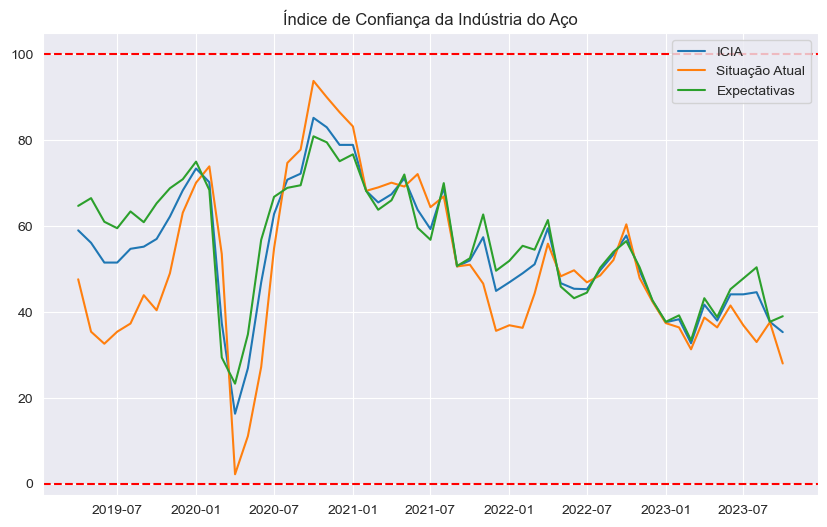

In [2]:
export_df = dados_meses.loc["Comércio Exterior"].transpose()
import_df = dados_meses.loc["Importações"].transpose()
producao_df = dados_meses.loc["Produção"].transpose()
internas_df = dados_meses.loc["Vendas Internas"].transpose()
externas_df = dados_meses.loc["Vendas Externas"].transpose()
consumo_df = dados_meses.loc["Consumo Aparente"].transpose()

def ICIA(filepath):
    icia = pd.read_excel(filepath[0])
    icia.set_index("Indicadores", inplace=True)
    icia = icia.transpose()

    lista_conf = ["ICIA", "Situação Atual", "Expectativas"]

    plt.figure(figsize=(10, 6))
    for i in lista_conf:
        plt.plot(icia[i])
    plt.axhline(y=100, color='r', linestyle='--', label='Upper Bound')
    plt.axhline(y=0, color='r', linestyle='--', label='Lower Bound')
    plt.title("Índice de Confiança da Indústria do Aço")
    plt.legend([x for x in lista_conf])
    plt.show()
    
    return icia

icia = ICIA(filepath)

<br>

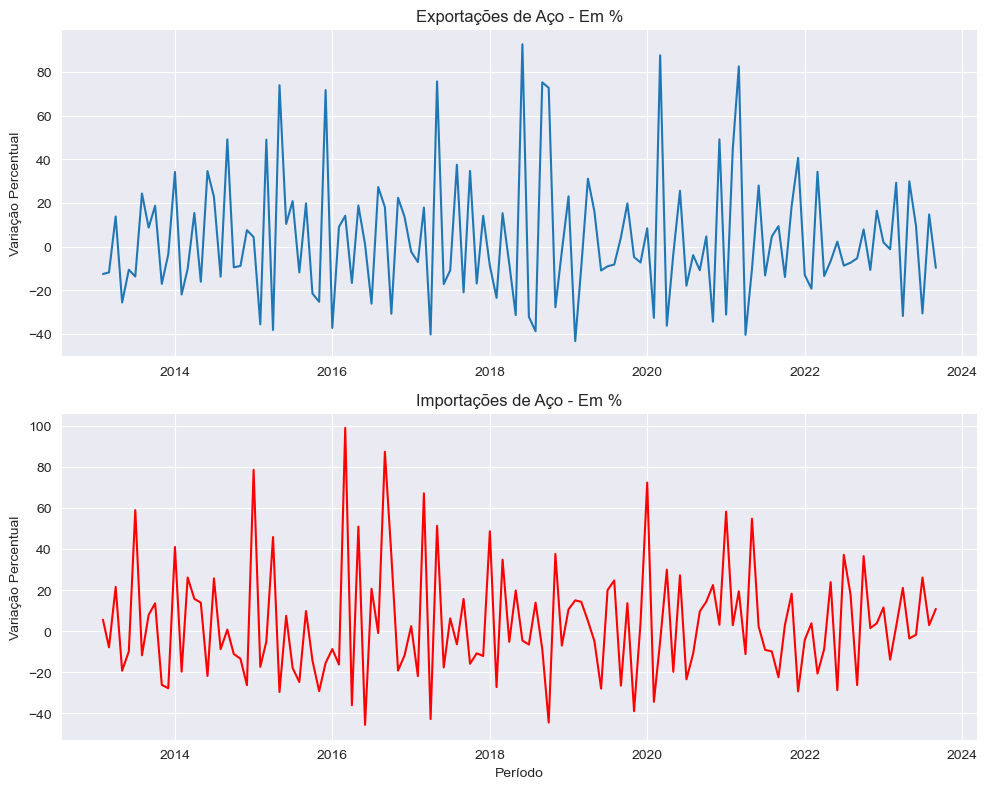

In [3]:
def export_import(is_pct):
    export_df = dados_meses.loc["Comércio Exterior"].transpose()
    import_df = dados_meses.loc["Importações"].transpose()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    if is_pct == False:
        ax1.plot(export_df["Total (Mil Toneladas) (Comércio Exterior)"])
        ax1.set_title("Exportações de Aço - Em Mil Toneladas")
        ax1.set_ylabel("Mil Toneladas")

        ax2.plot(import_df["Total (Mil Toneladas) (Importações)"],color="r")
        ax2.set_title("Importações de Aço - Em Mil Toneladas")
        ax2.set_ylabel("Mil Toneladas")
        ax2.set_xlabel("Período")

        plt.tight_layout()
    
    if is_pct == True:
        ax1.plot(export_df["Total (Mil Toneladas) (Comércio Exterior)"].pct_change()*100)
        ax1.set_title("Exportações de Aço - Em %")
        ax1.set_ylabel("Variação Percentual")

        ax2.plot(import_df["Total (Mil Toneladas) (Importações)"].pct_change()*100,color="r")
        ax2.set_title("Importações de Aço - Em %")
        ax2.set_ylabel("Variação Percentual")
        ax2.set_xlabel("Período")

        plt.tight_layout()
    return plt.show()

export_import(True)

<br>

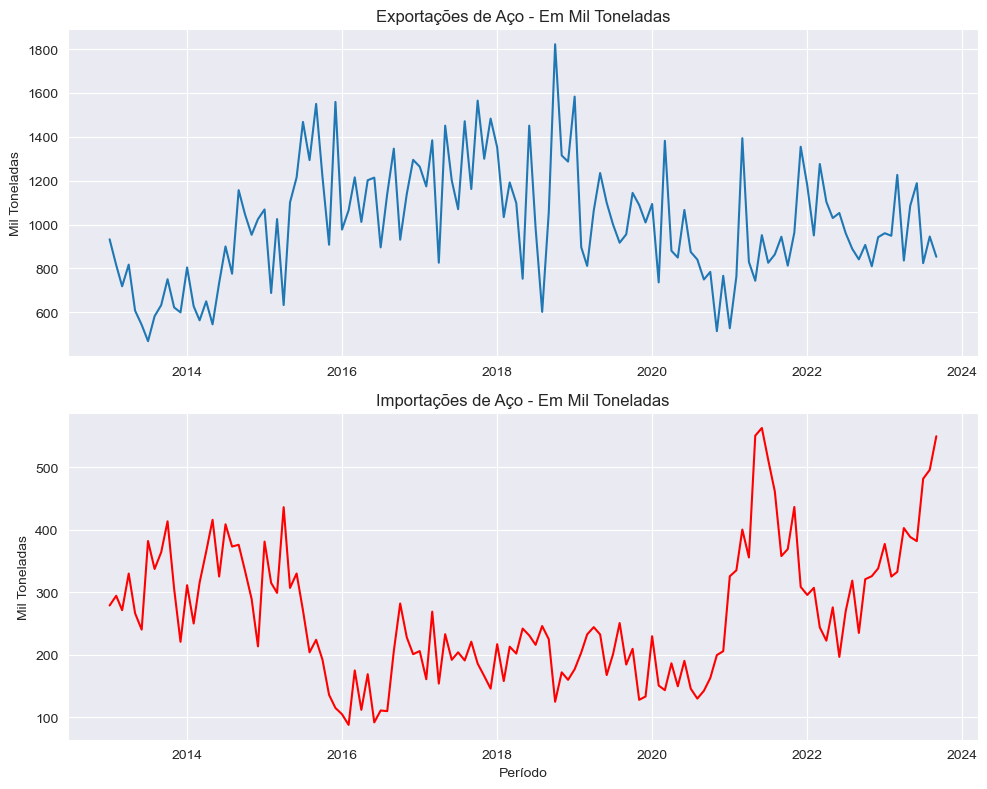

In [4]:
export_import(False)

<br>

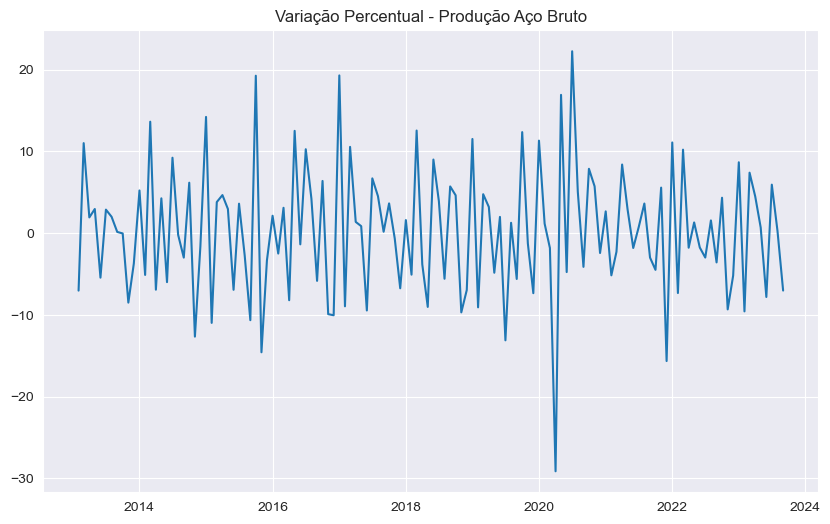

In [5]:
def lineplotf(source,index,is_pct):
    df = dados_meses.loc[source].transpose()
    
    if is_pct == True:
        plt.figure(figsize=(10,6))
        plt.plot(df[index].pct_change()*100)
        plt.title(f"Variação Percentual - {source} {index}")
        
    if is_pct == False:
        plt.figure(figsize=(10,6))
        plt.plot(df[index])
        plt.title(f"Série Histórica - {source} {index}")
    
    return plt.show()

lineplotf("Produção","Aço Bruto",True)

<br>

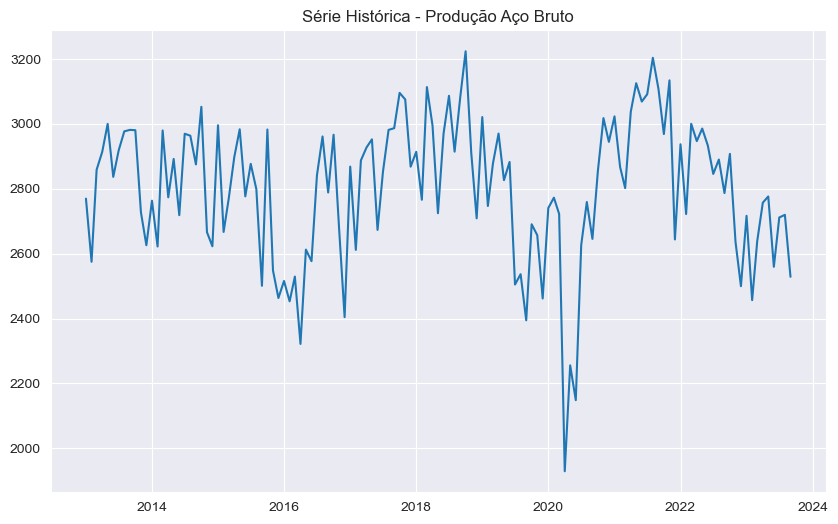

In [6]:
lineplotf("Produção","Aço Bruto",False)

In [7]:
def calcula_stats(df, column):
    media = round(df[column].mean(), 2)
    mediana = round(df[column].median(), 2)
    moda = round(df[column].mode()[0], 2)
    desv_pad = round(df[column].std(), 2)
    variancia = round(df[column].var(), 2)
    prints = print(f"Estatísticas Descritivas: {column}\n\nMédia: {media}\nMediana: {mediana}\nModa: {moda}\nDesvio Padrão: {desv_pad}\nVariância: {variancia}")
    
    return prints

calcula_stats(producao_df,"Aço Bruto")

Estatísticas Descritivas: Aço Bruto

Média: 2799.62
Mediana: 2841.27
Moda: 1929.29
Desvio Padrão: 219.77
Variância: 48300.82


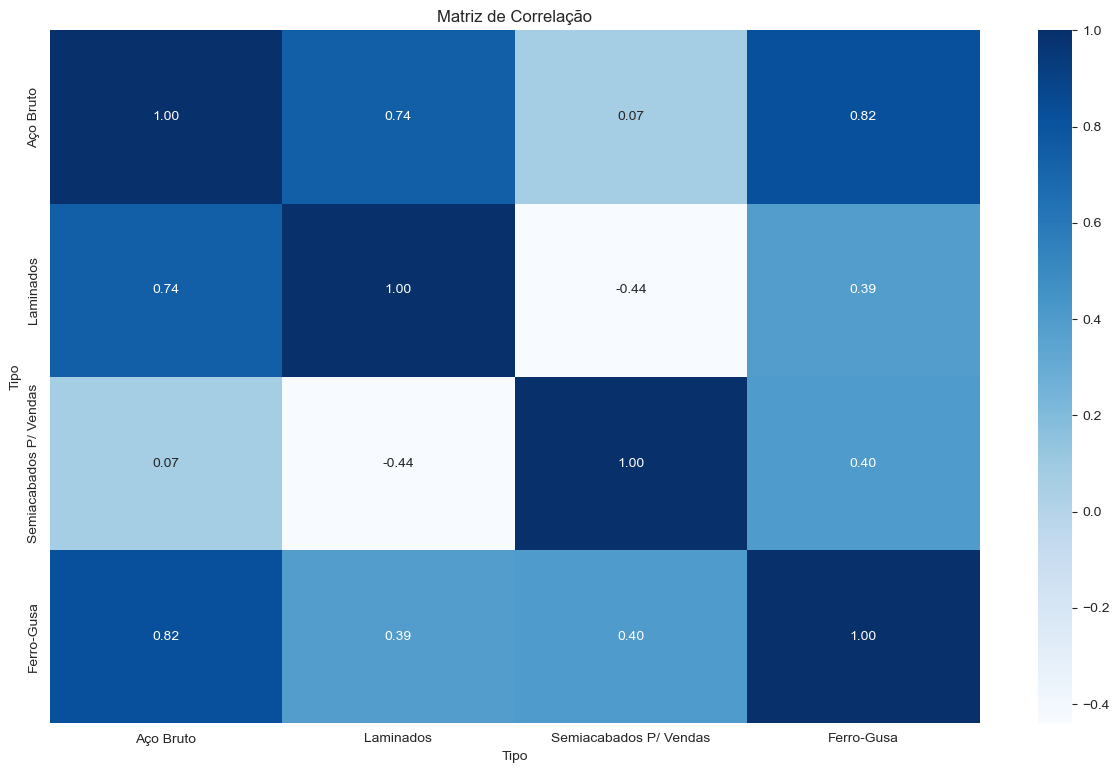

Tipo,Aço Bruto,Laminados,Semiacabados P/ Vendas,Ferro-Gusa
Tipo,,,,
Aço Bruto,1.00,0.74,0.07,0.82
Laminados,0.74,1.00,-0.44,0.39
Semiacabados P/ Vendas,0.07,-0.44,1.00,0.40
Ferro-Gusa,0.82,0.39,0.40,1.00


In [8]:
def correl(df):
    correlacao = df.corr().round(2)
    plt.figure(figsize=(15, 9))
    sns.heatmap(correlacao, annot=True, cmap="Blues", fmt=".2f")
    plt.title("Matriz de Correlação")
    plt.show()
    
    return correlacao

correl(producao_df)

<br>

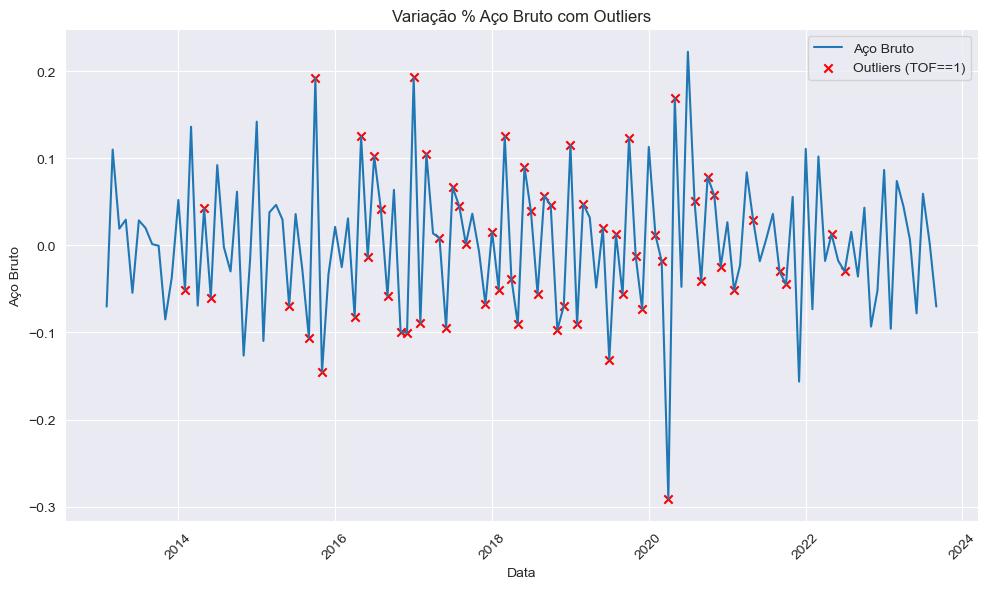

,Aço Bruto,TOF_score,TOF
2013-01-01,NaN,NaN,NaN
2013-02-01,-0.070246,127.000000,0.0
2013-03-01,0.110151,57.560837,0.0
2013-04-01,0.019276,93.664294,0.0
2013-05-01,0.029569,86.339446,0.0
...,...,...,...
2023-05-01,0.006950,68.492700,0.0
2023-06-01,-0.078045,77.982370,0.0
2023-07-01,0.059355,97.447422,0.0
2023-08-01,0.002988,65.717197,0.0


In [9]:
def outlier_detect(df, column):
    clean_data = detect_outlier(df[[column]].pct_change(), cutoff_n=50)

    plt.figure(figsize=(10, 6))
    plt.plot(clean_data.index, clean_data[column], label=column)
    plt.scatter(clean_data[clean_data["TOF"] == 1].index, clean_data[clean_data["TOF"] == 1][column], marker='x', color='red', label="Outliers (TOF==1)")
    plt.xlabel("Data")
    plt.ylabel(f"{column}")
    plt.title(f"Variação % {column} com Outliers")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return clean_data

outlier_detect(producao_df, "Aço Bruto")

<br>

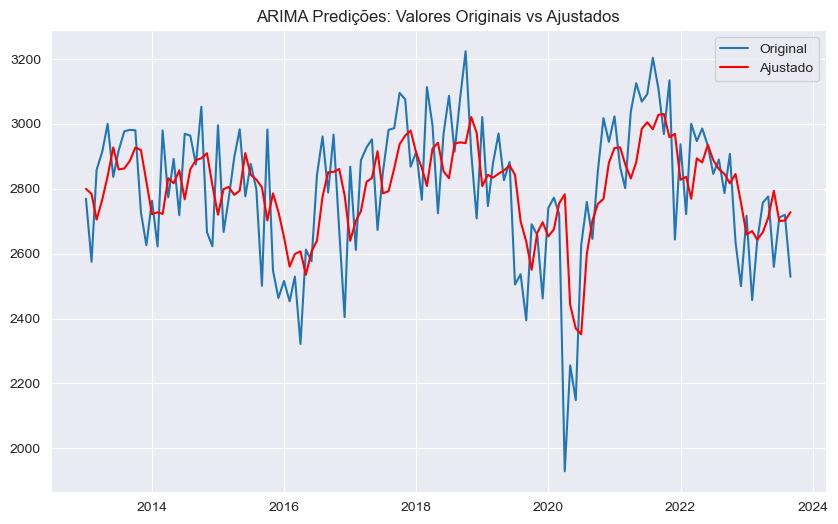

                               SARIMAX Results                                
Dep. Variable:              Aço Bruto   No. Observations:                  129
Model:                 ARIMA(5, 0, 0)   Log Likelihood                -852.058
Date:                Thu, 02 Nov 2023   AIC                           1718.116
Time:                        17:35:50   BIC                           1738.134
Sample:                    01-01-2013   HQIC                          1726.250
                         - 09-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2799.6239     55.188     50.728      0.000    2691.457    2907.791
ar.L1          0.3771      0.098      3.856      0.000       0.185       0.569
ar.L2          0.2512      0.104      2.417      0.0

In [10]:
def analise_temporal(df, coluna):
    modelo = ARIMA(df[coluna], order=(5, 0, 0))
    ajuste_modelo = modelo.fit()
    plt.figure(figsize=(10, 6))
    plt.plot(df[coluna], label='Original')
    plt.plot(ajuste_modelo.fittedvalues, color='red', label='Ajustado')
    plt.title('ARIMA Predições: Valores Originais vs Ajustados')
    plt.legend()
    plt.show()
    
    print(ajuste_modelo.summary())
    return ajuste_modelo

ajuste_modelo = analise_temporal(producao_df, 'Aço Bruto')

<br>

Insira o número de atributos: 3

Defina a variável explicativa 1: Laminados

Defina a variável explicativa 2: Semiacabados P/ Vendas

Defina a variável explicativa 3: Ferro-Gusa
    Fator VIF               atributos
0  171.079373               Laminados
1   53.775500  Semiacabados P/ Vendas
2  347.530348              Ferro-Gusa

Defina a variável alvo: Aço Bruto


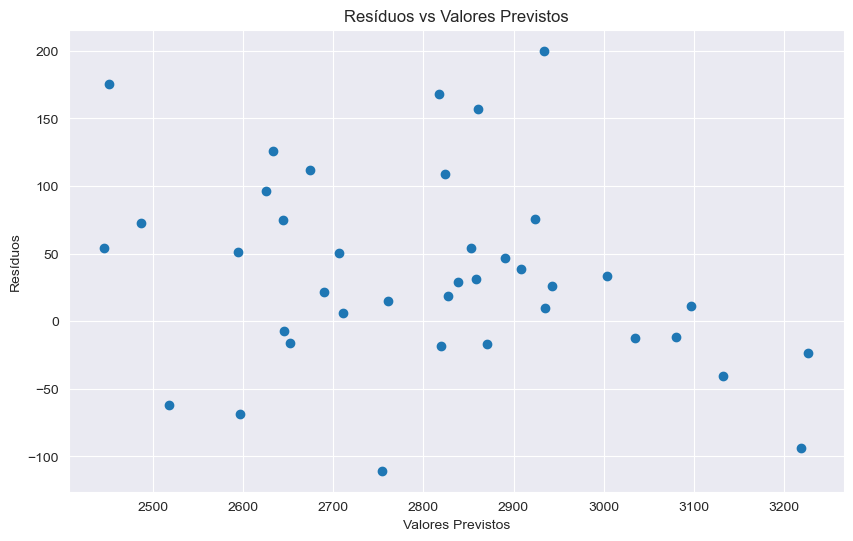


R-Quadrado: 83.00%

Erro Médio Absoluto: 60.16

Raiz do Erro Médio Quadrático: 78.86

Erro Médio Percentual Absoluto: 2.13%

Mais de uma coluna em df_atributos, gráfico de dispersão não é possível.


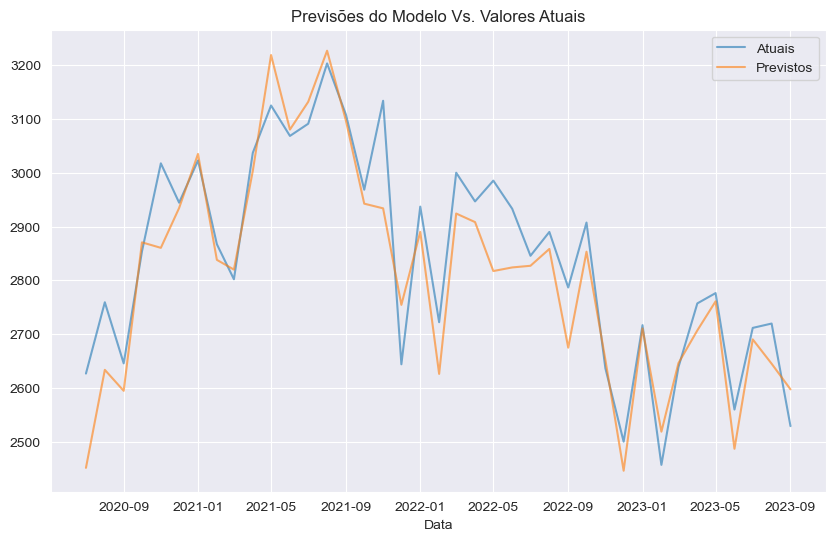

,Previstos,Atuais
2023-05-01,2760.799566,2776.125
2023-06-01,2486.513040,2559.461
2023-07-01,2689.995677,2711.379
2023-08-01,2644.795533,2719.481
2023-09-01,2597.052281,2528.615


In [11]:
def run_model(fonte, fonte2):
    colunas_modelo = []
    num_atributos = int(input("Insira o número de atributos: "))
    for i in range(0, num_atributos):
        colunas_modelo.append(input(f"\nDefina a variável explicativa {i+1}: "))

    df_atributos = fonte[colunas_modelo]
    
    if num_atributos > 1:
        # Verificação de multicolinearidade
        vif = pd.DataFrame()
        vif["Fator VIF"] = [variance_inflation_factor(df_atributos.values, i) for i in range(df_atributos.shape[1])]
        vif["atributos"] = df_atributos.columns
        print(vif)

    variavel_alvo = input("\nDefina a variável alvo: ")  
    df_classe = fonte2[variavel_alvo]

    X_treino, X_teste, y_treino, y_teste = train_test_split(df_atributos, df_classe, test_size=0.3, shuffle=False)
    
    regressor = LinearRegression()

    regressor.fit(X_treino, y_treino)

    prever_y = regressor.predict(X_teste)
    
    # Análise de resíduos
    resiudos = y_teste - prever_y
    plt.figure(figsize=(10, 6))
    plt.scatter(prever_y, resiudos)
    plt.title("Resíduos vs Valores Previstos")
    plt.xlabel("Valores Previstos")
    plt.ylabel("Resíduos")
    plt.show()

    r2 = r2_score(y_teste, prever_y, force_finite=False)
    mae = mean_absolute_error(y_teste, prever_y)
    rmse = mean_squared_error(y_teste, prever_y, squared=False)  # RMSE
    mape = np.mean(np.abs((y_teste - prever_y) / y_teste)) * 100  # MAPE

    print(f"\nR-Quadrado: {r2 * 100:.2f}%")
    print(f"\nErro Médio Absoluto: {mae:.2f}")
    print(f"\nRaiz do Erro Médio Quadrático: {rmse:.2f}")
    print(f"\nErro Médio Percentual Absoluto: {mape:.2f}%")
    
    if df_atributos.shape[1] == 1:
        plt.figure(figsize=(10, 6))
        plt.scatter(X_teste, y_teste)
        plt.plot(X_teste, prever_y, color='red')
        plt.xlabel(f"{colunas_modelo[0]}")
        plt.ylabel(f"{variavel_alvo}")
        plt.title(f"Gráfico de Dispersão - {colunas_modelo[0]} X {variavel_alvo}")
        plt.show()
    else:
        print("\nMais de uma coluna em df_atributos, gráfico de dispersão não é possível.")
        
    resultado_df = pd.DataFrame({'Previstos': prever_y, 'Atuais': y_teste})
    plt.figure(figsize=(10, 6))
    plt.xlabel("Data")
    plt.title("Previsões do Modelo Vs. Valores Atuais")
    plt.plot(resultado_df["Atuais"], alpha=0.6)
    plt.plot(resultado_df["Previstos"], alpha=0.6)
    plt.legend(["Atuais", "Previstos"])
    plt.show()
    
    return resultado_df.tail()

run_model(producao_df,producao_df)